# 1. Tokenisation

In deze notebook laden we de commentaren van de enquête in en passen we tokenisation toe: het splitsen van de tekst in aparte woorden/entiteiten.

## 1.1 Imports

We laden uitbreidingen in die we nodig hebben om de dataset in te laden.


[spaCy](https://spacy.io/) is een bekende package om tekst te parsen en verwerken. Met spaCy kan je héél veel (POS-taggen, tokenisen, lemmatisen, named entity recognition). Wij gaan gewoon alles opsplitsen in woordjes.

Ik heb [load_spacy](https://github.com/BramVanroy/spacy_download) van collega Bram Vanroy gebruikt, omdat dit automatisch ook het model downloadt als je het nog niet hebt. Verder werkt alles zoals je zou verwachten van spaCy.

In [7]:
import pandas as pd
from spacy_download import load_spacy
import os
import seaborn as sns
import matplotlib.pyplot as plt

nlp = load_spacy("nl_core_news_lg", exclude=["parser", "tagger"])
nlp.add_pipe("sentencizer")
nlp

## 1.2 Dataset inladen

We laden de dataset in en tonen een preview.

In [8]:
df = pd.read_csv("data/data_anon.csv")

## 1.3 Tokenisation

Deze onderstaande code neemt alle open commentaren uit de enquête, verwerkt deze tot lemma's en linkt ze aan de desbetreffende persoon.
Per lemma wordt het zinsnummer, lemmanummer, respondent-ID, part of speech en het woord in originele vorm bijgehouden.

De canonenquête bevatte 7 toelichtingsvragen en 2 open vragen:
- Q9: De aandacht voor de canon in voortgezet/secundair onderwijs.
- Q10: Leerlingen in het voortgezet/secundair onderwijs moeten enkele klassiekers lezen.
- Q11: Leerlingen in het voortgezet/secundair onderwijs moeten een elementaire kennis aangeboden krijgen van Nederlandstalige literatuurgeschiedenis
- Q14: Een Nederlandstalige literaire canon moet streven naar genderdiversiteit.
- Q15: Er kunnen meerdere Nederlandstalige literaire canons naast elkaar bestaan.
- Q16: Welke teksten uit de voormalige koloniale gebieden zouden in de canon moeten?
- Q17: Welke teksten uit de kinder- en jeugdliteratuur zouden in de canon moeten?
- QI: Heb je ideeën voor projecten die de canon in de kijker kunnen zetten?
- QC: Eventuele opmerkingen

Onderstaande code bundelt deze vragen samen waarbij nog steeds iedere vraag, user en sentence number herkenbaar zijn in de dataframe.

In [9]:
#De volgende code sorteert de open vragen uit de enquête en voegt ze toe aan een dictionary. 
ELAB = {question for question in df if "ELAB" in question}
ELAB.add("QPERS_IDEAS")
ELAB.add("QPERS_COMPLAIN")

rows = [] # een lege lijst om te vullen met de lemma's

#Via een function is het mogelijk om voor iedere open vraag dezelfde code te gebruiken waarin alles gecombineerd wordt
def add_row(question_prefix, row, sentence_number, token_number, token):
    identifier_prefix = question_prefix.replace('ELAB', '').replace('QPERS_IDEAS', 'QI_').replace('QPERS_COMPLAIN', 'QC_')
    #new_row element bepaalt de structuur van hoe de lemma's opgeslaan worden
    new_row = {
        "identifier": identifier_prefix + row["ResponseId"] + '_' + str(sentence_number) + '_' + str(token_number),
        "response_id": row["ResponseId"],
        "sentence_number": sentence_number,
        "token_number": token_number,
        "token": token.text,
        "lemma": token.lemma_,
        "pos": token.pos_
    }
    rows.append(new_row)
    
#Onderstaande loop gaat over iedere vraag in de vooraf gedefinieerde ELAB-lijst met open-commentaarvragen
for question in ELAB:
    #Lege rijen worden met deze code overgeslaan
    for index, row in df.iterrows():
        if pd.isnull(row[str(question)]):
            continue
        #Via de NLP-module worden de lemma's uit het woord afgeleid
        doc = nlp(row[str(question)])
        for sentence_number, sentence in enumerate(doc.sents): #via enumerate worden het aantal zinnen per respondent bijgehouden
            for token_number, token in enumerate (sentence):   #Hetzelfde wordt hier gedaan per woord
                if "ELAB" in question or "IDEAS" in question or "COMPLAIN" in question:
                    add_row(question, row, sentence_number, token_number, token)
                else:
                    continue

#Nadat het programma door alle vragen is gegaan, worden alle lemma's opgeslaan in een dataframe               
large_df = pd.DataFrame(rows)

# Sentimentwaarden toevoegen aan de dataset

Via de dataset van het CRR UGent ... (verder uittypen)

Via onderstaande worden een aantal kolommen toegevoegd waarin zowel de valentie-, opwinding- als dominantiewaarden voor ieder woord wordt toegevoegd, zowel in de gemiddelde waarde als de standaarddeviatiewaarde.

In [10]:
right_df = pd.read_csv('data/4299WordNorms Moors et al.csv')
left_df = large_df

merged_df = left_df.merge(right_df, left_on='lemma', right_on='Words', how='left')
merged_df = merged_df.drop(columns=['Words'])

# Demografische gegevens toevoegen

Via onderstaande code worden de geanonimiseerde demografische gegevens opnieuw gelinkt aan ieder lemma. Hierdoor is het mogelijk om de lemma's te analyseren.

In [11]:
df = pd.read_csv('data/data_anon.csv') #de data van het CRR wordt geladen in een andere dataframe
#via een subset dataframe worden enkel response_ID en de demografische gegevens geladen voor een snellere verwerking
demographics_subset = df[['ResponseId', 'QPERS_GENDER', 'QPERS_LANG', 'QPERS_EDU', 'QPERS_LING_JOB', 'QPERS_BIRTH_COUNTRY', 'QPERS_READING', 'QPERS_AGE']]
#de kolom van de originele data wordt hernoemd zodat deze overeenkomt met de vorige code.
demographics_subset.rename(columns={'ResponseId': 'response_id'}, inplace=True)
demo_merged_df = pd.merge(merged_df, demographics_subset, on='response_id')
#Rijen waar er geen sentimentwaarden voor bestaan (denk aan "een") worden overgeslaan.
if not os.path.exists('sorted_data'): #Dit maakt een map aan indien er geen zou bestaan
    os.makedirs('sorted_data')
merged_df_final = demo_merged_df.dropna()
merged_df_final.to_csv('sorted_data/Combined_Ratings.csv') #de gecombineerde data wordt opgeslaan

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\80146965.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_subset.rename(columns={'ResponseId': 'response_id'}, inplace=True)


# Eerste visualisaties

Hieronder vind je een aantal visualisaties die ik gemaakt heb om de code beter te begrijpen. Dit zijn nog niet de uiteindelijke resultaten die ik zal gebruiken, maar zullen nog verfijnd worden.

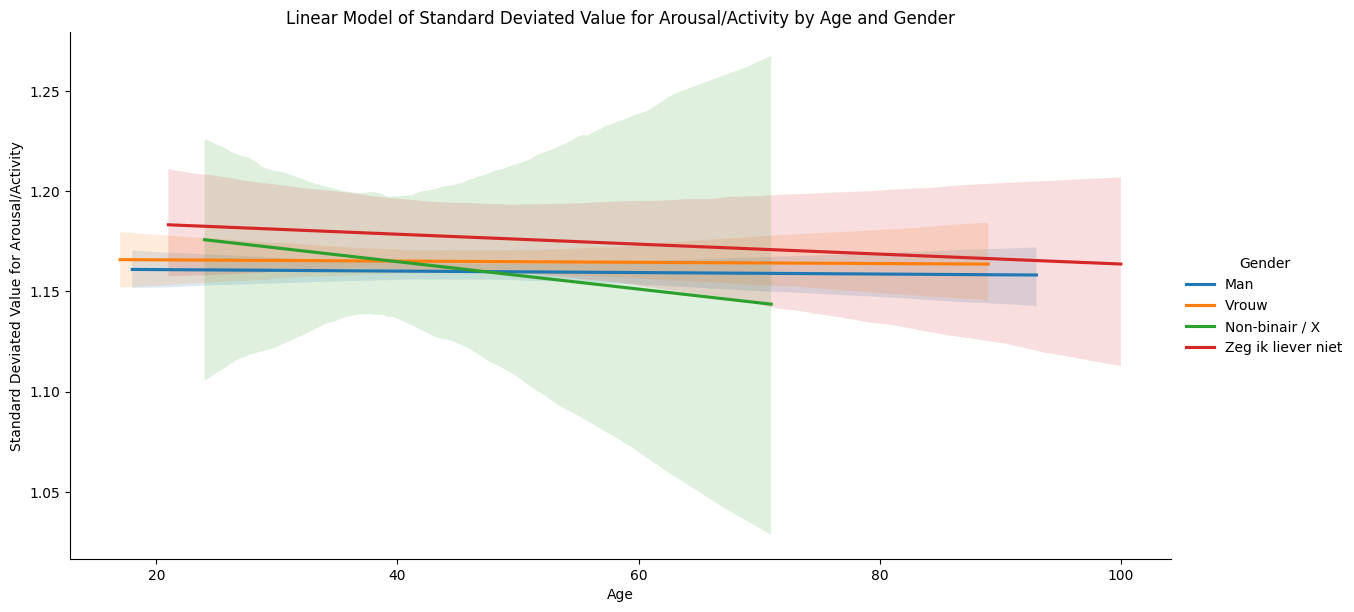

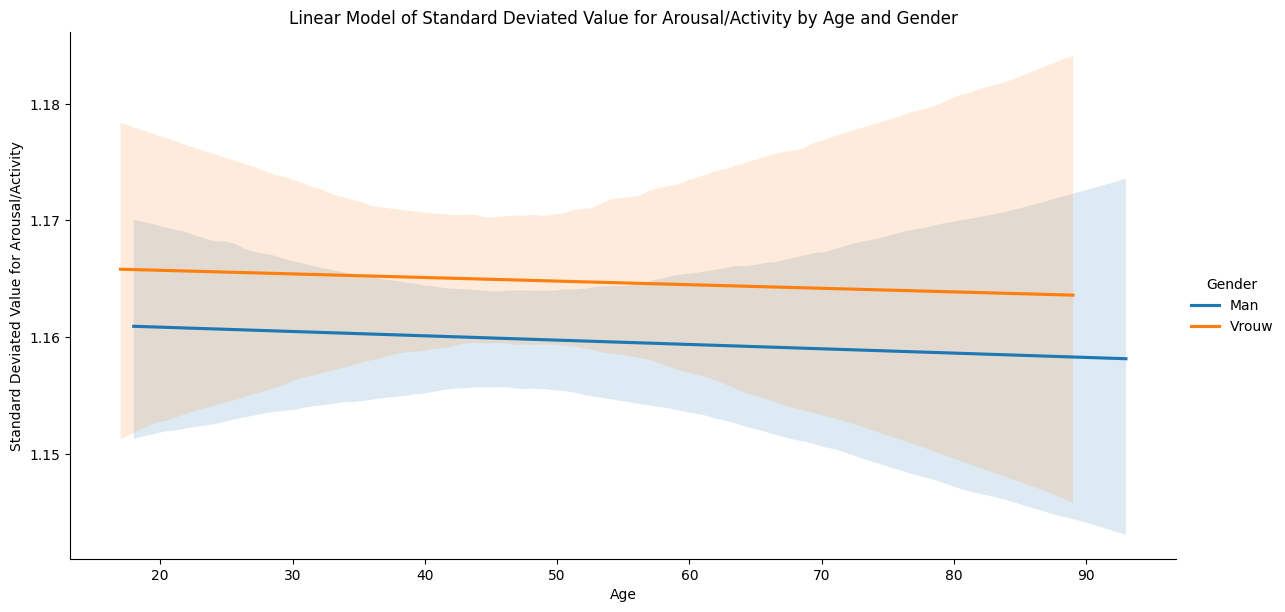

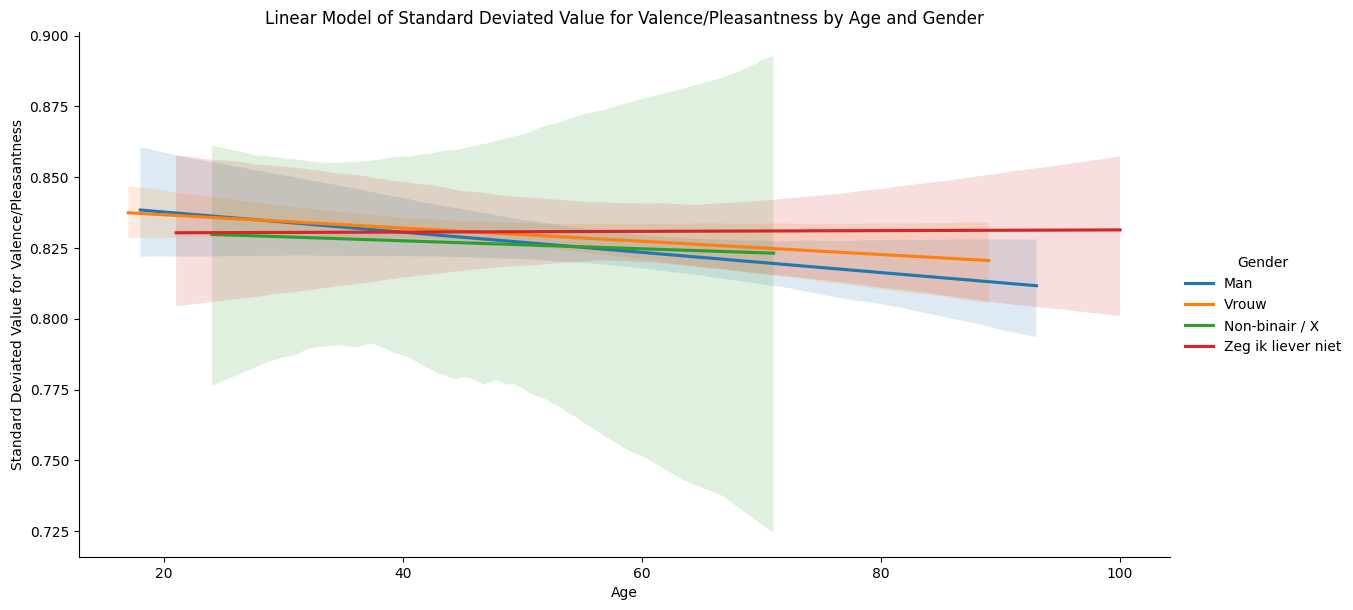

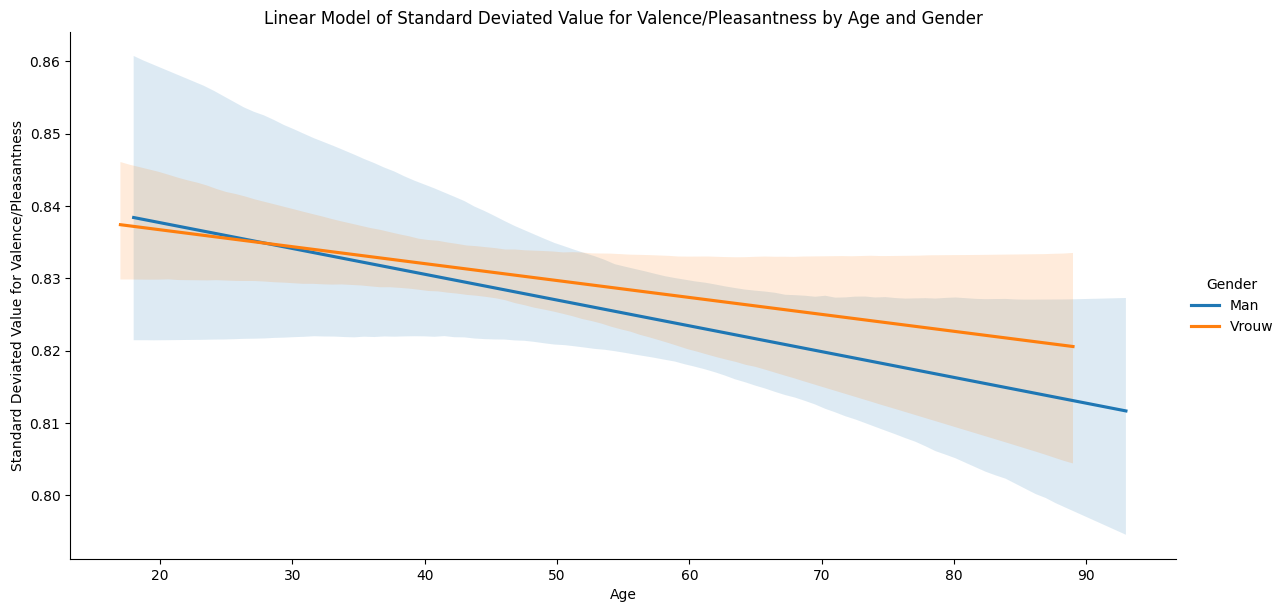

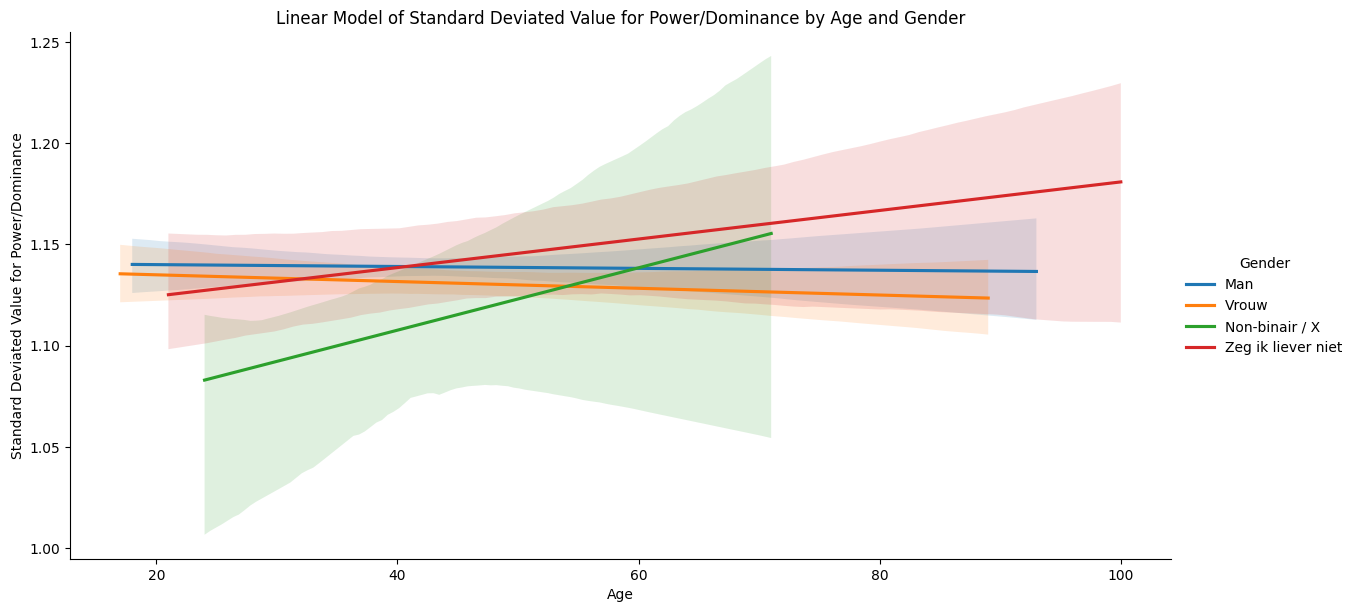

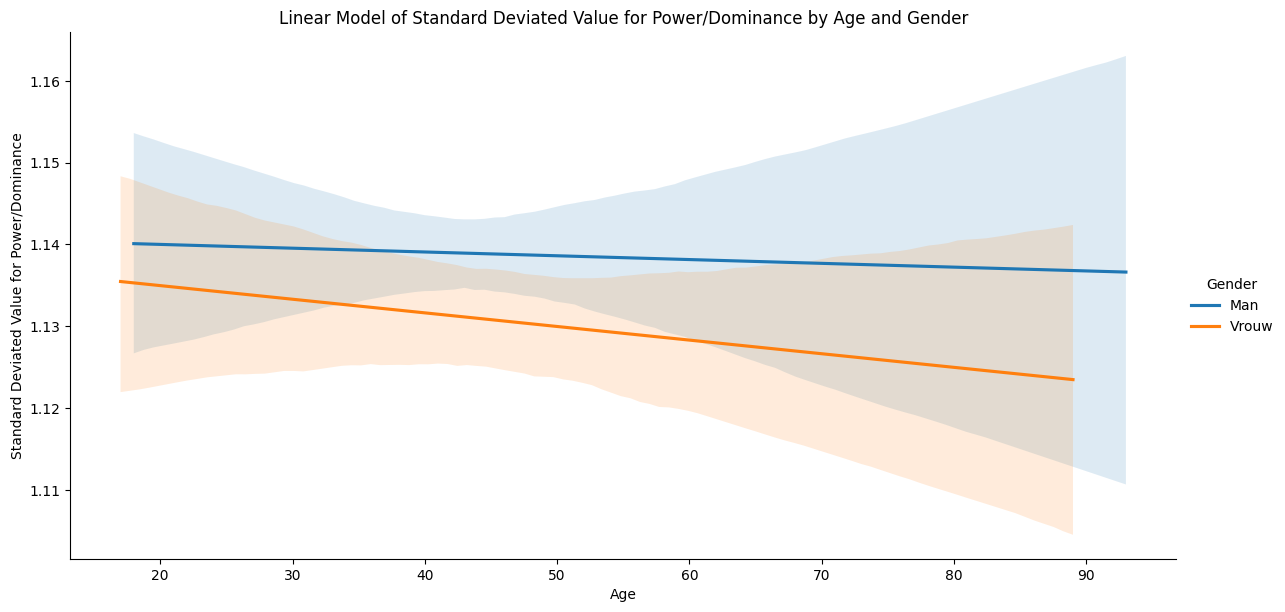

In [12]:
#Een kopie wordt gebruikt van de dataset zodat indien we zaken aanpassen
#de oorspronkelijke gegevens blijven bestaan
visual_df = merged_df_final.copy()
#Gender wordt veranderd van naam zodat deze duidelijker is in de grafiek
visual_df.rename(columns={'QPERS_GENDER': 'Gender'}, inplace=True)
#De orde van de items wordt hier bepaalt, zodat
#Man & Vrouw telkens dezelfde kleuren hebben
gender_order = ["Man", "Vrouw", "Non-binair / X", "Zeg ik liever niet"]
filtered_gender_order = ["Man", "Vrouw"]
#De abstracte woordratings worden duidelijker gemaakt via volgende lijnen
wordnorms=['SD A', 'SD V', 'SD P']
wordnormlabels = {
    'SD A': 'Standard Deviated Value for Arousal/Activity',
    'SD V': 'Standard Deviated Value for Valence/Pleasantness',
    'SD P': 'Standard Deviated Value for Power/Dominance'
}
#Een functie die de grafieken zal maken voor alle waarden.
def plot_lm(data, x, y, hue, title, xlabel, ylabel, hue_order):
    sns.lmplot(data=data, x=x, y=y, hue=hue, height=6, aspect=2, scatter=False, hue_order=hue_order)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

#Dataframe filteren op enkel man en vrouw
filtered_df = visual_df.query("Gender in ['Man', 'Vrouw']")

#Door middel van een forloop worden alle woordnormen toegevoegd en verwerkt tot een lineair model
for wordnorm in wordnorms:
    label = wordnormlabels[wordnorm]
    grouped_data = visual_df.groupby(['Gender', 'QPERS_AGE'])[wordnorm].mean().reset_index()
    plot_lm(grouped_data, 'QPERS_AGE', wordnorm, 'Gender', f'Linear Model of {label} by Age and Gender', 'Age', label, gender_order)

    #De code wordt gedeeltelijk herhaald voor de gefilterde dataset voor enkel mannen en vrouwen
    grouped_filtered_data = filtered_df.groupby(['Gender', 'QPERS_AGE'])[wordnorm].mean().reset_index()
    plot_lm(grouped_filtered_data, 'QPERS_AGE', wordnorm, 'Gender', f'Linear Model of {label} by Age and Gender', 'Age', label, filtered_gender_order)

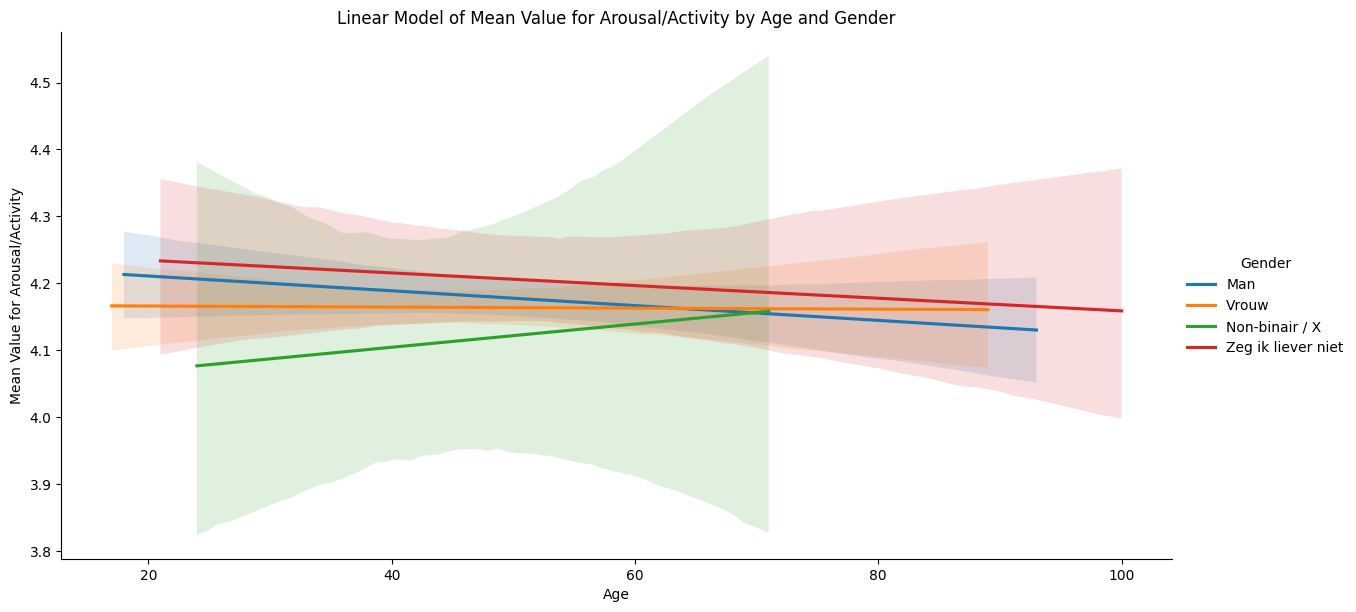

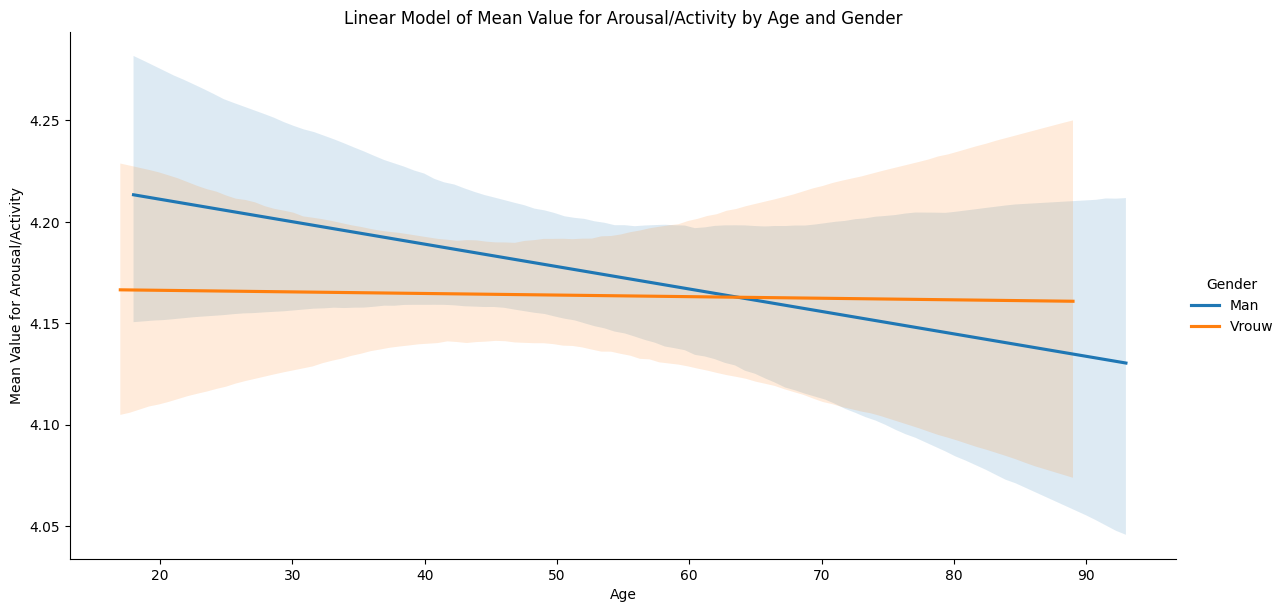

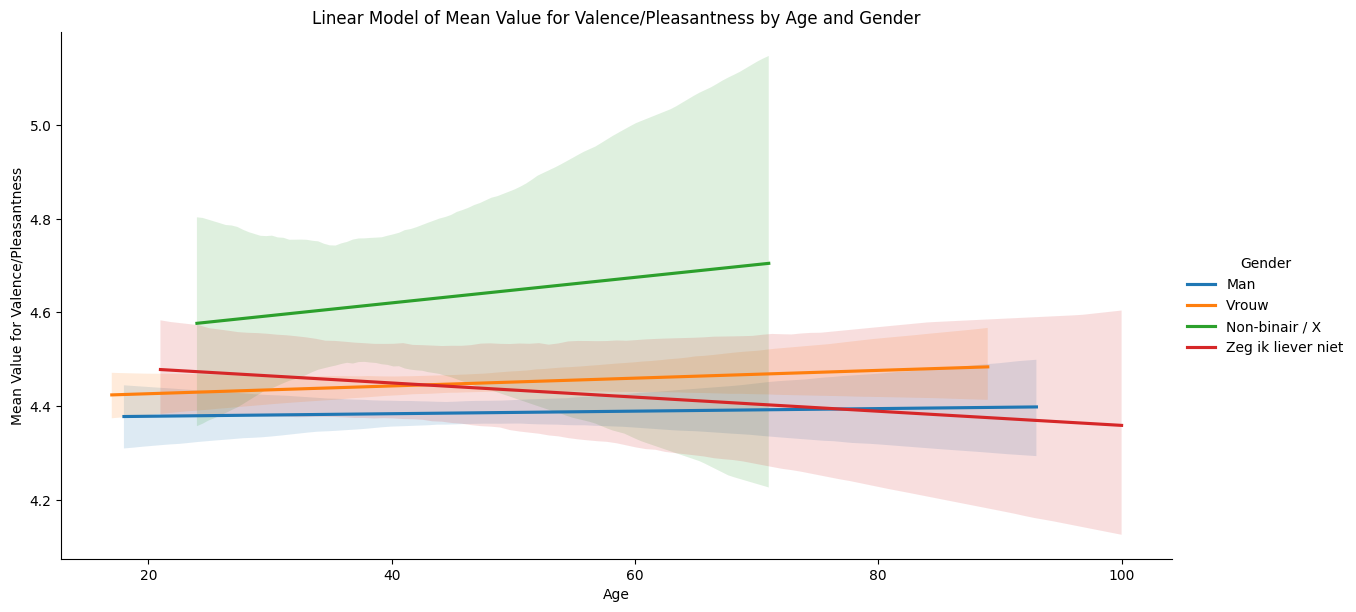

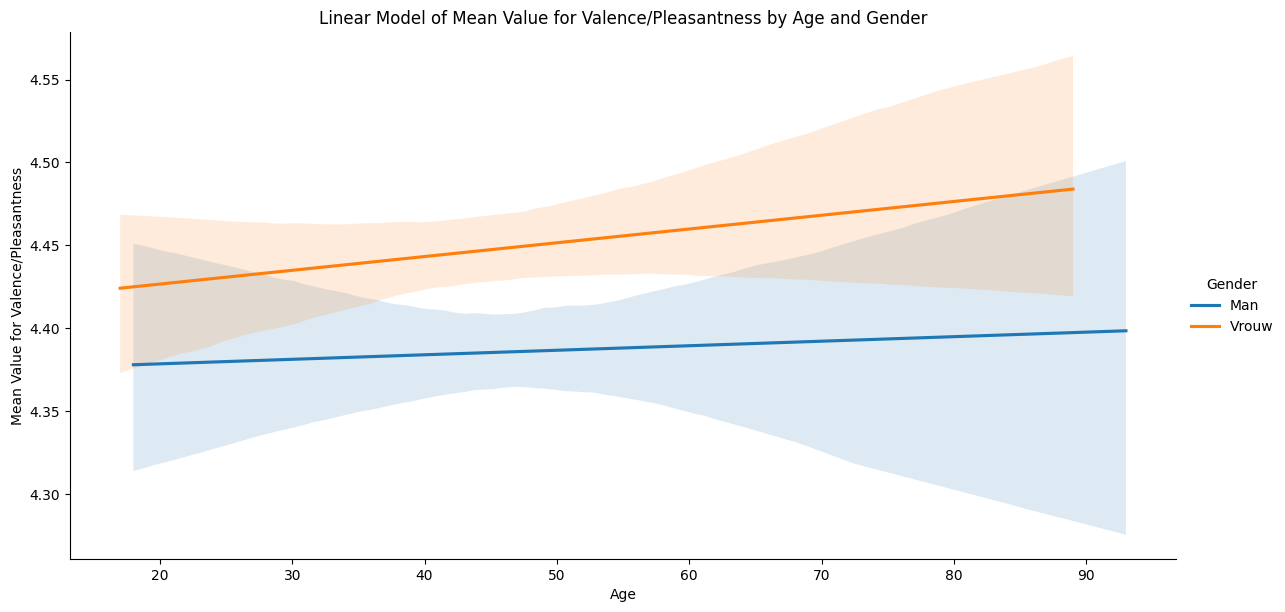

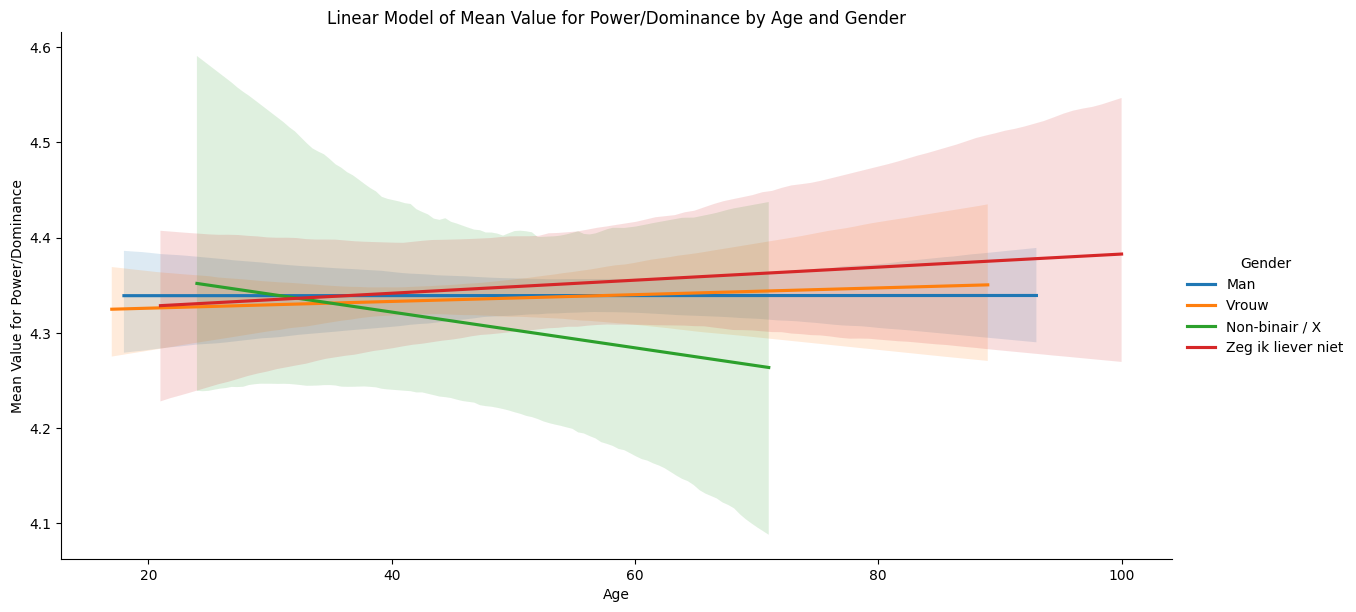

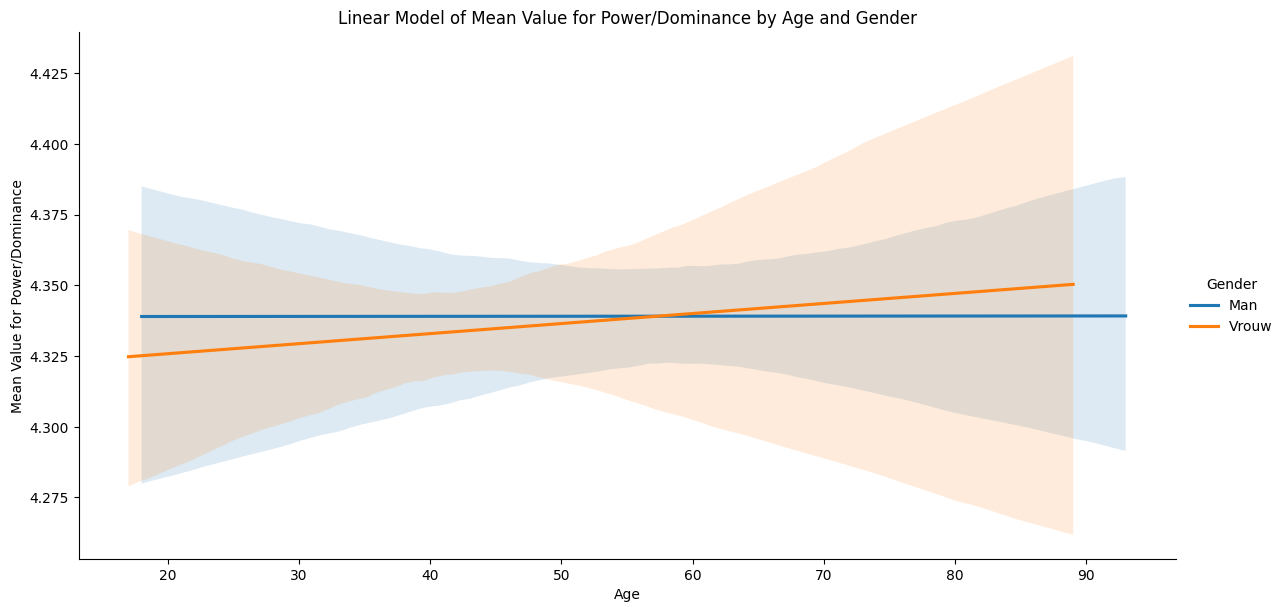

In [13]:
#Een kopie wordt gebruikt van de dataset zodat indien we zaken aanpassen
#de oorspronkelijke gegevens blijven bestaan
visual_df = merged_df_final.copy()
#Gender wordt veranderd van naam zodat deze duidelijker is in de grafiek
visual_df.rename(columns={'QPERS_GENDER': 'Gender'}, inplace=True)
#De orde van de items wordt hier bepaalt, zodat
#Man & Vrouw telkens dezelfde kleuren hebben
gender_order = ["Man", "Vrouw", "Non-binair / X", "Zeg ik liever niet"]
filtered_gender_order = ["Man", "Vrouw"]
#De abstracte woordratings worden duidelijker gemaakt via volgende lijnen
wordnorms=['M A', 'M V', 'M P']
wordnormlabels = {
    'M A': 'Mean Value for Arousal/Activity',
    'M V': 'Mean Value for Valence/Pleasantness',
    'M P': 'Mean Value for Power/Dominance'
}
#Een functie die de grafieken zal maken voor alle waarden.
def plot_lm(data, x, y, hue, title, xlabel, ylabel, hue_order):
    sns.lmplot(data=data, x=x, y=y, hue=hue, height=6, aspect=2, scatter=False, hue_order=hue_order)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

#Dataframe filteren op enkel man en vrouw
filtered_df = visual_df.query("Gender in ['Man', 'Vrouw']")

#Door middel van een forloop worden alle woordnormen toegevoegd en verwerkt tot een lineair model
for wordnorm in wordnorms:
    label = wordnormlabels[wordnorm]
    grouped_data = visual_df.groupby(['Gender', 'QPERS_AGE'])[wordnorm].mean().reset_index()
    plot_lm(grouped_data, 'QPERS_AGE', wordnorm, 'Gender', f'Linear Model of {label} by Age and Gender', 'Age', label, gender_order)

    #De code wordt gedeeltelijk herhaald voor de gefilterde dataset voor enkel mannen en vrouwen
    grouped_filtered_data = filtered_df.groupby(['Gender', 'QPERS_AGE'])[wordnorm].mean().reset_index()
    plot_lm(grouped_filtered_data, 'QPERS_AGE', wordnorm, 'Gender', f'Linear Model of {label} by Age and Gender', 'Age', label, filtered_gender_order)

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\1353418858.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility


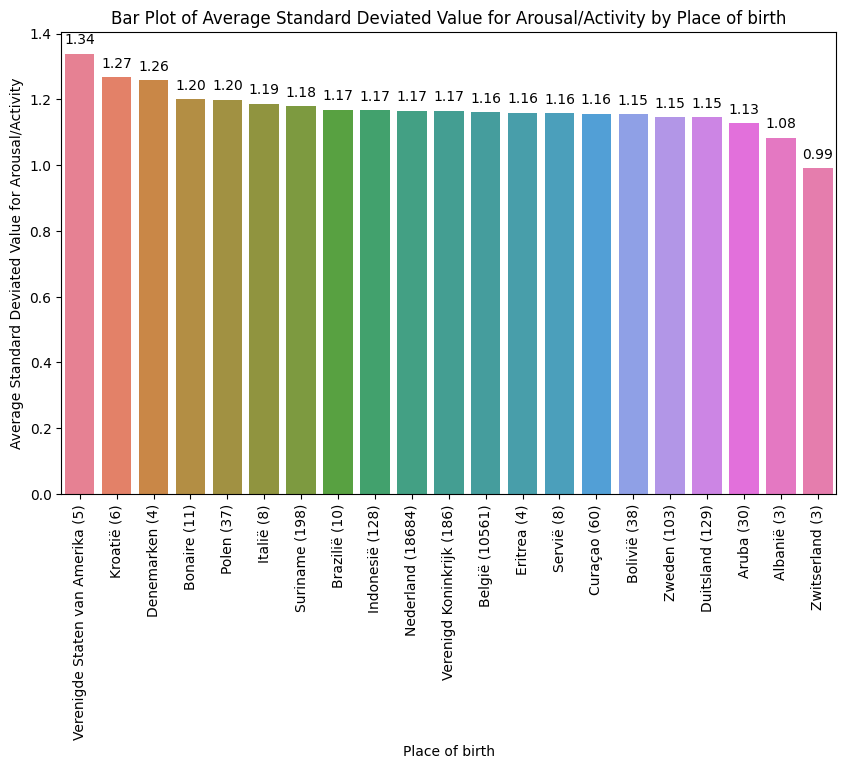

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\1353418858.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility


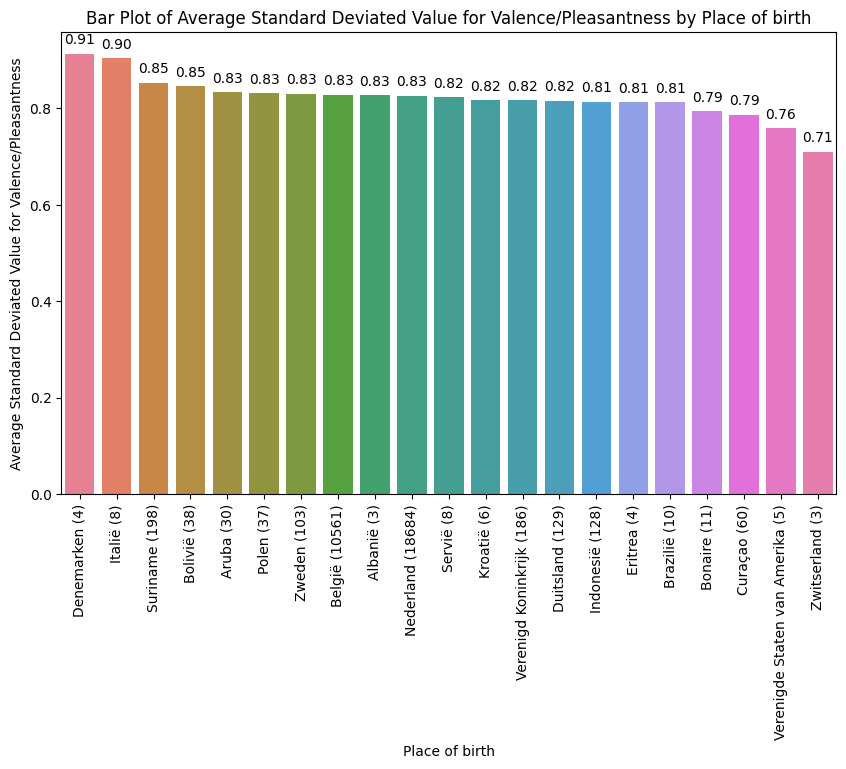

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\1353418858.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility


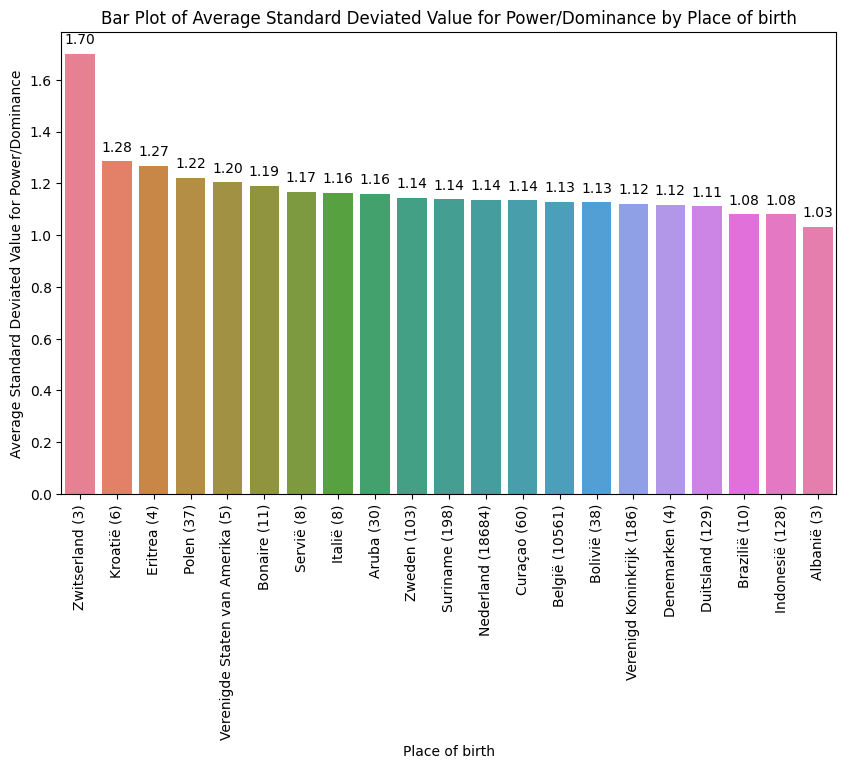

In [14]:
#Een kopie wordt gebruikt van de dataset zodat indien we zaken aanpassen
#de oorspronkelijke gegevens blijven bestaan
visual_df = merged_df_final.copy()

#Birth country wordt veranderd van naam zodat deze duidelijker is in de grafiek
visual_df.rename(columns={'QPERS_BIRTH_COUNTRY': 'Place of birth'}, inplace=True)

#De abstracte woordratings worden duidelijker gemaakt via volgende lijnen
wordnorms=['SD A', 'SD V', 'SD P']
wordnormlabels = {
    'SD A': 'Standard Deviated Value for Arousal/Activity',
    'SD V': 'Standard Deviated Value for Valence/Pleasantness',
    'SD P': 'Standard Deviated Value for Power/Dominance'
}

#Een functie die de grafieken zal maken voor alle waarden.
def plot_bar(data, x, y, title, xlabel, ylabel, hue, counts):
    plt.figure(figsize=(10,6))
    barplot = sns.barplot(data=data, x=x, y=y, hue=hue)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    #X-as wordt aangepast om het aantal waarden te tonen
    labels = [f'{label} ({count})' for label, count in zip(data[x], counts)]
    barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility

    #Het gemiddelde aantal wordt bovenaan iedere kolom toegevoegd
    for i, p in enumerate(barplot.patches):
        barplot.annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

    plt.show()

#Via de forloop worden alle woordnormen behandeld en verwerkt
for wordnorm in wordnorms:
    label = wordnormlabels[wordnorm]
    #De data wordt gegroepeerd per geboorteland en het gemiddelde aantal per land
    grouped_df = visual_df.groupby('Place of birth')[wordnorm].mean().reset_index()
    #De data wordt gesorteerd van hoog naar laag
    grouped_df = grouped_df.sort_values(by=wordnorm, ascending=False)
    #Het aantal lemma's per geboorteland worden onderaan weergegeven
    counts = visual_df['Place of birth'].value_counts().loc[grouped_df['Place of birth']].values
    plot_bar(grouped_df, 'Place of birth', wordnorm, f'Bar Plot of Average {label} by Place of birth', 'Place of birth', f'Average {label}', 'Place of birth', counts)

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\2939663001.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility


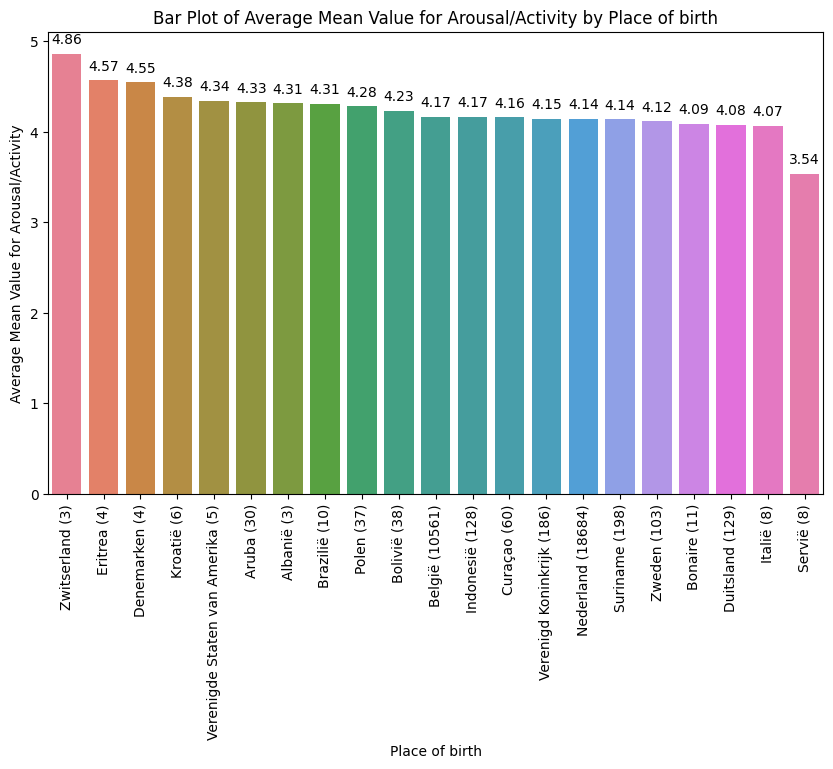

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\2939663001.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility


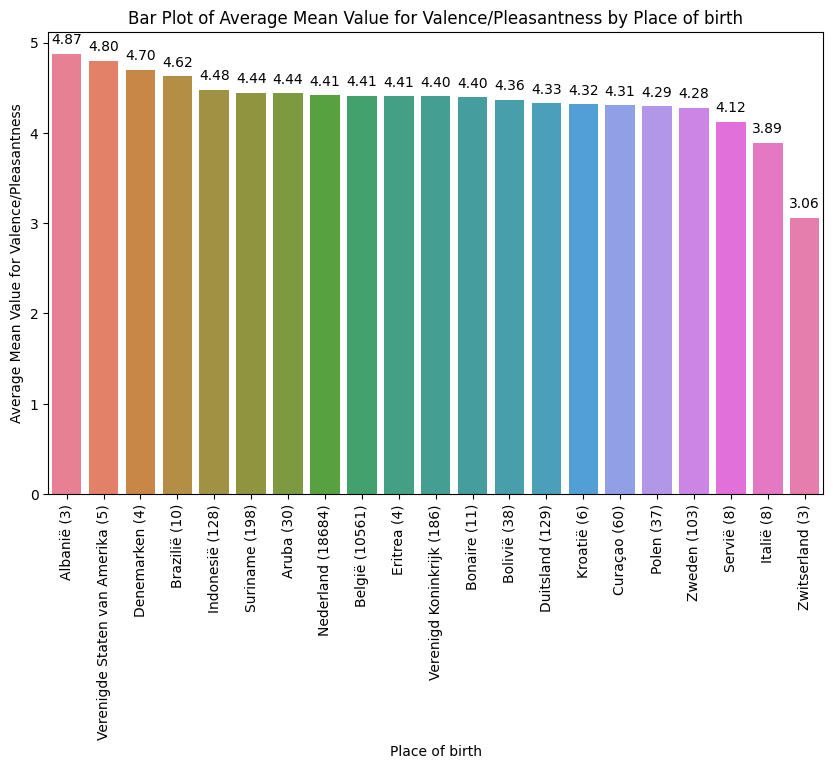

C:\Users\lean\AppData\Local\Temp\ipykernel_2184\2939663001.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility


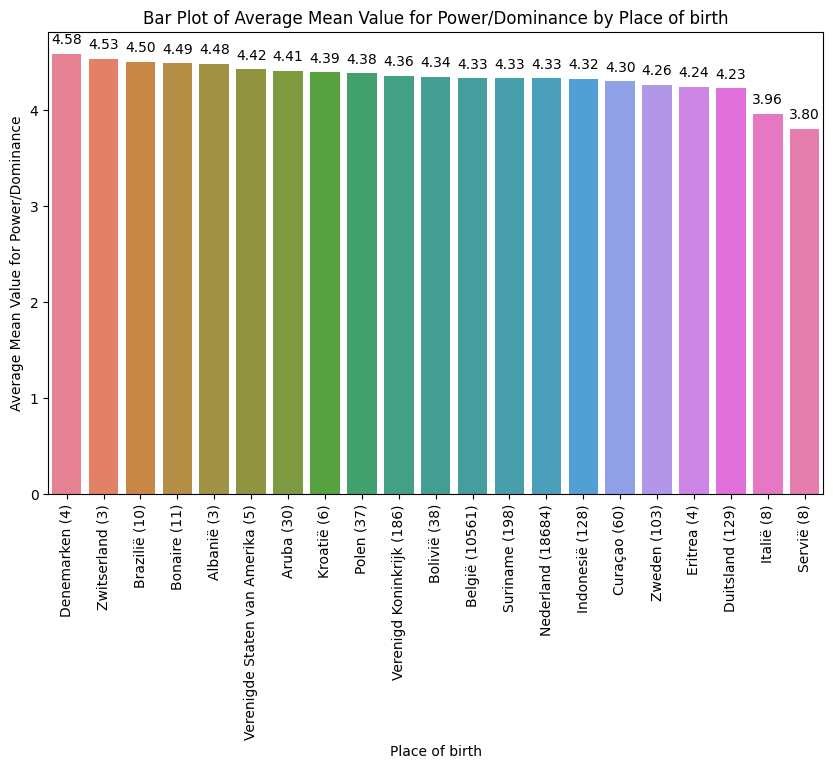

In [15]:
#Een kopie wordt gebruikt van de dataset zodat indien we zaken aanpassen
#de oorspronkelijke gegevens blijven bestaan
visual_df = merged_df_final.copy()

#Birth country wordt veranderd van naam zodat deze duidelijker is in de grafiek
visual_df.rename(columns={'QPERS_BIRTH_COUNTRY': 'Place of birth'}, inplace=True)

#De abstracte woordratings worden duidelijker gemaakt via volgende lijnen
wordnorms=['M A', 'M V', 'M P']
wordnormlabels = {
    'M A': 'Mean Value for Arousal/Activity',
    'M V': 'Mean Value for Valence/Pleasantness',
    'M P': 'Mean Value for Power/Dominance'
}

#Een functie die de grafieken zal maken voor alle waarden.
def plot_bar(data, x, y, title, xlabel, ylabel, hue, counts):
    plt.figure(figsize=(10,6))
    barplot = sns.barplot(data=data, x=x, y=y, hue=hue)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    #X-as wordt aangepast om het aantal waarden te tonen
    labels = [f'{label} ({count})' for label, count in zip(data[x], counts)]
    barplot.set_xticklabels(labels, rotation=90)  # Rotate x-axis labels for better visibility

    #Het gemiddelde aantal wordt bovenaan iedere kolom toegevoegd
    for i, p in enumerate(barplot.patches):
        barplot.annotate(f'{p.get_height():.2f}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

    plt.show()

#Via de forloop worden alle woordnormen behandeld en verwerkt
for wordnorm in wordnorms:
    label = wordnormlabels[wordnorm]
    #De data wordt gegroepeerd per geboorteland en het gemiddelde aantal per land
    grouped_df = visual_df.groupby('Place of birth')[wordnorm].mean().reset_index()
    #De data wordt gesorteerd van hoog naar laag
    grouped_df = grouped_df.sort_values(by=wordnorm, ascending=False)
    #Het aantal lemma's per geboorteland worden onderaan weergegeven
    counts = visual_df['Place of birth'].value_counts().loc[grouped_df['Place of birth']].values
    plot_bar(grouped_df, 'Place of birth', wordnorm, f'Bar Plot of Average {label} by Place of birth', 'Place of birth', f'Average {label}', 'Place of birth', counts)